# Ibis
Created: 09/13/2024\
Updated: 09/25/2024

## TODO
Add more series to RDFN dataset

## Setup Environment

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import add_trading_hours
from fredapi import Fred
from openai import OpenAI

In [2]:
# MUST SET COMPUTING ENVIRONMENT
COMPUTING_ENV = 'windows'
#COMPUTING_ENV = 'ubuntu'
#COMPUTING_ENV = 'aws'

In [ ]:
os.getcwd()

In [ ]:
if COMPUTING_ENV == 'windows':
    WORKING_DIR = "C:\\Users\\regin\\Dropbox\\ibis"
    API_KEYS_DIR = "C:\\Users\\regin\\Dropbox\\API_KEYS"
elif COMPUTING_ENV == 'ubuntu':
    WORKING_DIR = "/home/reggie//Dropbox/ibis"
    API_KEYS_DIR = "/home/reggie/Dropbox/API_KEYS"
elif COMPUTING_ENV == 'aws':
    WORKING_DIR = "/home/ubuntu/ibis"
    API_KEYS_DIR = "/home/ubuntu/API_KEYS"

DATA_DIR = os.path.join(WORKING_DIR, "data")
STOCK_DATA_DIR  = os.path.join(DATA_DIR, 'tmp')
FRD_DATA_DIR = os.path.join(DATA_DIR, 'frd-historical')
print(f"Working directory is\n\t{WORKING_DIR}")
print(f"Data directory is\n\t{DATA_DIR}")
print(f"Stock data directory is\n\t{STOCK_DATA_DIR}")
print(f"FRD data directory is\n\t{FRD_DATA_DIR}")

# data dictionary
data_dictionary_fp = os.path.join(DATA_DIR, "data_dictionary.json")
if not os.path.exists(data_dictionary_fp):
    print(f"Data dictionary does not exist in {data_dictionary_fp}. Initializing empty data dictionary.")
    data_dictionary = {}
else:
    print(f"Data dictionary exists in {data_dictionary_fp}. Loading data dictionary.")
    with open(data_dictionary_fp, "r") as f:
        data_dictionary = json.load(f)
    print('\tKeys:', data_dictionary.keys())

# OpenAI API key
openai_api_key_fp = os.path.join(API_KEYS_DIR, 'openai-api-key-1.txt')
with open(openai_api_key_fp) as f:
    OPENAI_API_KEY = f.read().strip()
print(f"OpenAI API key is loaded")

# FRED Data
fred_api_key_fp = os.path.join(API_KEYS_DIR, 'FRED-API-KEY')
with open(fred_api_key_fp) as f:
    fred_api_key = f.read().strip()
print(f"FRED API key loaded")
FRED_DIR = os.path.join(DATA_DIR, "FRED")
fred_daily_data_fp = os.path.join(FRED_DIR, 'daily', 'FRED_daily.csv')
if not os.path.exists(fred_daily_data_fp):
    print(f"FRED daily data do not exist in {fred_daily_data_fp}.")
else:
    print(f"FRED daily data are in {fred_daily_data_fp}")

# a table to map asset types to download directories
frd_download_directories = pd.read_csv(os.path.join(FRD_DATA_DIR, 'frd-download-directories.csv'))
frd_download_directories


# Utilities

In [5]:
def load_stock_prices(ticker, asset_type, period='full', timeframe='1min', adjustment='adj_splitdiv', data_dir='./'):
    if asset_type == 'stock':
        csv_filename = f"{ticker}_{period}_{timeframe}_{adjustment.replace('_','')}.txt"
        fp = os.path.join(data_dir, csv_filename)
        prices_df = pd.read_csv(
            fp,
            sep=",",
            names=['date', 'open', 'high', 'low', 'close', 'volume'],
            header=0,  # Assuming the first row is a header, if not set to None
            on_bad_lines='warn',  # Skip bad lines
            engine='python'  # Use the Python engine for more flexible error handling
        )
    elif asset_type == 'index':
        csv_filename = f"{ticker}_{period}_{timeframe}.txt"
        fp = os.path.join(data_dir, csv_filename)
        prices_df = pd.read_csv(
            fp,
            sep=",",
            names=['date', 'open', 'high', 'low', 'close',],
            header=0,  # Assuming the first row is a header, if not set to None
            on_bad_lines='warn',  # Skip bad lines
            engine='python'  # Use the Python engine for more flexible error handling
        )

    # Convert 'date' column to datetime if it's not already
    prices_df['date'] = pd.to_datetime(prices_df['date'])
    
    # Extract the day as YYYY-MM-DD
    prices_df['day'] = prices_df['date'].dt.date
    
    if period in ['1min', '5min', '30min', '1hour']:
        # Extract the time as HH:MM:SS
        prices_df['time'] = prices_df['date'].dt.time
        
        # Calculate the time ID (minute of the day from 1 to 1440)
        prices_df['time_id'] = prices_df['date'].dt.hour * 60 + prices_df['date'].dt.minute + 1
    
        prices_df.set_index('date', inplace=True)
        prices_df = add_trading_hours(prices_df)
    else:
        prices_df.set_index('date', inplace=True)

    # add returns
    prices_df.sort_index(inplace=True, ascending=True)
    prices_df['open_to_close_ret'] = prices_df['close']/prices_df['open'] - 1
    prices_df['close_to_close_ret'] = prices_df['close'].pct_change()
    prices_df['overnight_ret'] = prices_df['open']/prices_df['close'].shift(1) - 1
    prices_df['open_to_high_ret'] = prices_df['high']/prices_df['open'] - 1
    prices_df['open_to_low_ret'] = prices_df['low']/prices_df['open'] - 1
    prices_df['low_to_high'] = prices_df['high']/prices_df['low'] - 1 # max possible return

    prices_df['ticker'] = ticker
    
    return prices_df

# Load Index Data

In [ ]:
asset_type = 'index'
ticker = 'SPX'
period = 'full'
timeframe = '1day'
index_data_dir = os.path.join(FRD_DATA_DIR, frd_download_directories.query(f"type == '{asset_type}' & timeframe == '{timeframe}'")['directory'].values[0], 'csv')
print(f"Index data directory is {index_data_dir}")
spx_df = load_stock_prices(
    ticker=ticker,
    asset_type=asset_type,
    period=period,
    timeframe=timeframe,
    data_dir=index_data_dir
)
spx_df


# GPT Prompt

In [ ]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def parse_python_from_gpt_markdown(content: str, save: bool = False, filename: str = None):
    """This function takes in a ChatGPT response that is in Markdown form with Python code blocks and returns the Python code as a string.
    
    Parameters:
    ----------
        content : str : The ChatGPT response in Markdown form

    Returns:
    -------
        python_str : str : The Python code as a string
    """
    python_str = ""
    in_python_block = False
    for line in content.split("\n"):
        if line.startswith("```python"):
            in_python_block = True
        elif line.startswith("```"):
            in_python_block = False
        elif in_python_block:
            python_str += line + "\n"
    if save:
        with open(filename, "w") as f:
            f.write(python_str)
    return python_str

def gpt_code(system_prompt: str, user_prompt: str, filename, save, model='gpt-4-o') -> (str, str):

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": user_prompt,
            }
        ]
    )
    content = completion.choices[0].message.content
    return content, parse_python_from_gpt_markdown(content, save=False, filename=None)

# Downoad FRED Data

In [6]:
fred = Fred(api_key=fred_api_key)

fred_tips_series = ['DFII10', 'DFII5', 'DFII20', 'DFII30',]
fred_treasury_series = ['DGS10', 'DGS2', 'DGS30']

fred_tips_daily_data_fp = os.path.join(FRED_DIR, 'daily', 'FRED_daily_tips.csv')
fred_treasuries_daily_data_fp = os.path.join(FRED_DIR, 'daily', 'FRED_daily_treasuries.csv')

create_or_update_fred_tips_data = False
create_or_update_fred_treasuries_data = False

## Treasury Inflation-Indexed Securities

In [ ]:

if create_or_update_fred_tips_data:

    # create or update data dictionary
    for series in fred_tips_series:
        if series not in data_dictionary:
            data_dictionary[series] = dict(fred.get_series_info(series))
        else:
            print(f"{series} already in data dictionary.")

    # export data_dictionary to json
    with open(data_dictionary_fp, 'w') as f:
        json.dump(data_dictionary, f, indent=2)

    tips_df = pd.DataFrame({
        series: fred.get_series(series) for series in fred_tips_series
    })
    tips_df.reset_index(inplace=True)
    tips_df.rename(columns={"index": "date"}, inplace=True)
    tips_df['date'] = pd.to_datetime(tips_df['date'])
    tips_df.set_index('date', inplace=True)
    tips_df.to_csv(fred_tips_daily_data_fp)
else:
    tips_df = pd.read_csv(fred_tips_daily_data_fp, index_col='date', parse_dates=True)
tips_df


## Treasury Constant Maturity

In [ ]:
if create_or_update_fred_treasuries_data:
    for series in fred_treasury_series:
        if series not in data_dictionary:
            data_dictionary[series] = dict(fred.get_series_info(series))
        else:
            print(f"{series} already in data dictionary.")
            
    # export data_dictionary to json
    with open(data_dictionary_fp, 'w') as f:
        json.dump(data_dictionary, f, indent=2)

    treasuries_df = pd.DataFrame({
        series: fred.get_series(series) for series in fred_treasury_series
    })
    treasuries_df.reset_index(inplace=True)
    treasuries_df.rename(columns={"index": "date"}, inplace=True)
    treasuries_df['date'] = pd.to_datetime(treasuries_df['date'])
    treasuries_df.set_index('date', inplace=True)
    treasuries_df.to_csv(fred_treasuries_daily_data_fp)
else:
    treasuries_df = pd.read_csv(fred_treasuries_daily_data_fp, index_col='date', parse_dates=True)
treasuries_df

# Analyze Inflation and Interest Rate Data

### Load Series and Plot Levels and Changes

In [ ]:
fred_tips_daily_df = pd.read_csv(fred_tips_daily_data_fp, index_col='date', parse_dates=True)
X = fred_tips_daily_df.copy()
X.ffill(inplace=True)
X.dropna(inplace=True)

# add pct change
X_pct_change = X.pct_change()
X_pct_change.dropna(inplace=True)

plt.figure(figsize=(12, 8))
for col in X.columns:
    plt.plot(X.index, X[col], label=col)
plt.title("Treasury Inflation-Indexed Securities (TIPS)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for col in X_pct_change.columns:
    plt.plot(X_pct_change.index, X_pct_change[col], label=col)
plt.title("Treasury Inflation-Indexed Securities (TIPS) Percent Change")
plt.legend()
plt.show()

X_pct_change

### correlation matrix

In [ ]:
corr = X_pct_change.corr()
print(corr.round(2))

# heatmap
plt.figure(figsize=(6, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

In [ ]:
corr = X.corr()
print(corr.round(2))

# heatmap
plt.figure(figsize=(6, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

### Perform Singular Value Decomposition

In [ ]:
# SVD on daily treasuries
U, s, Vt = np.linalg.svd(X, full_matrices=False)

# s contains the singular values (variance explained by each component)
# U contains the left singular vectors (temporal patterns)
# Vt contains the right singular vectors (relationships between variables)

# Retain only top k components for dimensionality reduction
k = 3
U_k = U[:, :k]
S_k = np.diag(s[:k])
Vt_k = Vt[:k, :]

# Low-rank approximation of X
X_approx = np.dot(U_k, np.dot(S_k, Vt_k))

# Singular values show the importance of each component
print("Top singular values:", s[:10])

# Use Vt_k to analyze relationships between variables (columns of X)
print("Right singular vectors (V^T):\n", Vt_k)

# first two SVs as factors
factors = U_k



### Scree Plot (Singular Values)
A scree plot displays the magnitude of the singular values, which tells you how much variance each component explains. This can help identify how many components are important and where the diminishing returns occur.

In [ ]:
# Assume 's' contains the singular values from SVD
def plot_scree(s):
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(s) + 1), s, marker='o', linestyle='-')
    plt.title("Scree Plot of Singular Values")
    plt.xlabel("Component Number")
    plt.ylabel("Singular Value")
    plt.grid(True)
    plt.show()

# Example usage:
plot_scree(s[:50])  # Plot the first 50 singular values


### Cumulative Variance Explained

Another useful plot is the cumulative explained variance, which shows how much total variance is explained as you include more singular values. It helps to decide how many components are necessary to capture most of the variance.

In [ ]:
def plot_cumulative_variance(s):
    explained_variance = np.cumsum(s**2) / np.sum(s**2)
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(s) + 1), explained_variance, marker='o', linestyle='-')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.show()

# Example usage:
plot_cumulative_variance(s[:50])  # Plot cumulative variance for the first 50 components


### Heatmap of Top Singular Vectors (Right Singular Vectors $V^T$)

You can visualize the right singular vectors, which describe how the variables (columns of the original data) contribute to each principal component. A heatmap can highlight the relationship between variables and components.

This heatmap shows the contribution of each time series (variables) to the top principal components. Patterns, correlations, and groups of similar variables will be visible, showing how variables are related to each principal component.

In [ ]:
def plot_singular_vectors(Vt, k=10):
    plt.figure(figsize=(10, 6))
    sns.heatmap(Vt[:k, :], cmap='coolwarm', center=0)
    plt.title(f"Heatmap of Top {k} Right Singular Vectors (V^T)")
    plt.xlabel("Variables (Time Series)")
    plt.ylabel("Singular Vector Index")
    plt.show()

# Example usage:
plot_singular_vectors(Vt_k, k=10)  # Plot top 10 right singular vectors


### Time Series Projections (Left Singular Vectors U)

The left singular vectors represent temporal patterns. You can project the original time series data onto the top components and visualize these projections to understand the key dynamics of the system over time.

This plot shows how the time series evolve in terms of the most important components. You can spot trends, cycles, or other important temporal patterns.

In [ ]:
def plot_time_series_projections(U, components=[0, 1]):
    plt.figure(figsize=(10, 6))
    
    for comp in components:
        plt.plot(U[:, comp], label=f"Component {comp+1}")
    
    plt.title("Time Series Projections onto Top Components")
    plt.xlabel("Time Steps")
    plt.ylabel("Projection")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_time_series_projections(U_k, components=[0, 1])  # Plot the first two components


### 2D/3D Scatter Plot of Time Series in Reduced Space

By projecting the time series into a reduced space (using the top singular vectors), you can visualize the relationships between time steps or time series in lower dimensions (e.g., a 2D or 3D scatter plot).

These projections show how the data points cluster in lower dimensions, helping to identify groups, trends, or anomalies. In 2D or 3D, clusters or separations between groups of time steps or variables may become more evident.

In [ ]:
def plot_2d_projection(U, Vt, singular_values):
    # Project the data onto the first two components
    projection = np.dot(U[:, :2], np.diag(singular_values[:2]))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(projection[:, 0], projection[:, 1], alpha=0.5, s=10)
    plt.title("2D Projection of Time Series Data")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Example usage:
plot_2d_projection(U_k, Vt_k, s[:2])


In [ ]:
def plot_3d_projection(U, singular_values):
    # Project the data onto the first three components
    projection = np.dot(U[:, :3], np.diag(singular_values[:3]))
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], alpha=0.5, s=10)
    
    ax.set_title("3D Projection of Time Series Data")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    
    plt.show()

# Example usage:
plot_3d_projection(U_k, s[:3])


# Analyze Rates II

In [ ]:
X = tips_df.merge(treasuries_df, left_index=True, right_index=True, suffixes=('_tips', '_treasuries'))
# rename 'date' index to 'time_index'
X.index.rename('time_index', inplace=True)
X

In [ ]:
# number of minutes in a year
minutes_in_year = 525600

In [ ]:
k = 500
n = 100_000 # number of minutes
X = np.random.randn(n, k)
time_index = pd.date_range(start='2020-01-01', periods=len(X), freq='T')  # 'T' for minute frequency
X = pd.DataFrame(X, index=time_index).round(2)
X.columns = [f"feature_{i}" for i in range(k)]
print(X.shape)
X.head()
X.tail()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.decomposition import PCA
from scipy.signal import cwt, ricker
from scipy.fft import fft, fftfreq
import os
import warnings
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs('./figures', exist_ok=True)
os.makedirs('./tables', exist_ok=True)

# Assume your dataframe is X
# Replace 'target_column_name' with your actual target column name
target_col = 'feature_0'
target_series = X[target_col]

# List of temporal resolutions to examine
# Resample to coarser frequencies
resolutions = ['5T', '15T', '30T', '1H', '1D']  # 5 Minutes, 15 Minutes, 30 Minutes, Hourly, Daily

for res in resolutions:
    print(f"\nAnalyzing data resampled to {res} resolution.")
    
    # Resample the data
    X_resampled = X.resample(res).mean()
    target_resampled = X_resampled[target_col]
    
    # Save resampled target series
    target_resampled.to_csv(f'./tables/target_series_{res}.csv')
    
    # 1. Correlation Analysis at the current resolution
    correlations = X_resampled.corrwith(target_resampled).sort_values(ascending=False)
    top_correlations = correlations.head(10)
    print(f"Top correlated series with the target series at {res} resolution:")
    print(top_correlations)
    
    # Save top correlations to a CSV file
    top_correlations.to_csv(f'./tables/top_correlated_series_{res}.csv', header=['Correlation'])
    
    # Plot the top correlated series with the target series
    top_correlated_series = correlations.index[1:6]  # Exclude the first one (itself)
    for col in top_correlated_series:
        plt.figure(figsize=(12, 6))
        plt.plot(target_resampled.index, target_resampled.values, label='Target Series')
        plt.plot(target_resampled.index, X_resampled[col].values, label=f'Series {col}')
        plt.legend()
        plt.title(f'Target Series vs Series {col} at {res} resolution')
        plt.xlabel('Time')
        plt.ylabel('Value')
        # Save the plot
        plt.savefig(f'./figures/target_vs_series_{col}_{res}.png')
        plt.close()
    
    # 2. Stationarity Tests (ADF Test)
    adf_result = adfuller(target_resampled.dropna())
    adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(f"ADF Test Result for Target Series at {res} resolution:")
    print(adf_output)
    
    # Save ADF test result
    adf_output.to_csv(f'./tables/adf_test_{res}.csv', header=['Value'])
    
    # 3. Time Series Decomposition
    # Since STL requires a frequency, we need to set it based on the resampled data
    # For example, if resampling to '1H', the period might be 24 (hours in a day)
    freq_dict = {'5T': 288, '15T': 96, '30T': 48, '1H': 24, '1D': 7}  # Adjusted periods
    freq = freq_dict[res]
    stl = STL(target_resampled.dropna(), period=freq)
    stl_result = stl.fit()
    
    # Plot the decomposition
    stl_result.plot()
    plt.suptitle(f'STL Decomposition of Target Series at {res} resolution')
    plt.savefig(f'./figures/stl_decomposition_{res}.png')
    plt.close()
    
    # Save decomposition components
    decomposition_df = pd.DataFrame({
        'Trend': stl_result.trend,
        'Seasonal': stl_result.seasonal,
        'Residual': stl_result.resid
    }, index=target_resampled.dropna().index)
    decomposition_df.to_csv(f'./tables/stl_decomposition_{res}.csv')
    
    # 4. Spectral Analysis (Fourier Transform)
    n = len(target_resampled.dropna())
    yf = fft(target_resampled.dropna().values)  # Convert Series to NumPy array
    xf = fftfreq(n, 1)[:n//2]
    
    plt.figure(figsize=(12, 6))
    plt.plot(xf, 2.0/n * np.abs(yf[0:n//2]))
    plt.title(f'Frequency Domain of Target Series at {res} resolution')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.savefig(f'./figures/frequency_domain_{res}.png')
    plt.close()
    
    # Save frequency and amplitude data
    freq_ampl_df = pd.DataFrame({'Frequency': xf, 'Amplitude': 2.0/n * np.abs(yf[0:n//2])})
    freq_ampl_df.to_csv(f'./tables/frequency_domain_{res}.csv', index=False)
    
    # 5. Wavelet Transform (Time-Frequency Analysis)
    widths = np.arange(1, 31)
    cwt_matr = cwt(target_resampled.fillna(0).values, ricker, widths)  # Convert Series to NumPy array
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cwt_matr, extent=[0, len(target_resampled), 1, 31], cmap='PRGn', aspect='auto',
               vmax=abs(cwt_matr).max(), vmin=-abs(cwt_matr).max())
    plt.title(f'Continuous Wavelet Transform of Target Series at {res} resolution')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.savefig(f'./figures/cwt_{res}.png')
    plt.close()
    
    # Note: Saving the entire wavelet matrix may not be practical due to size
    
    # 6. PCA at the current resolution
    pca = PCA(n_components=5)
    principal_components = pca.fit_transform(X_resampled.fillna(0))
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance Ratios by Principal Components at {res} resolution:")
    for i, ev in enumerate(explained_variance):
        print(f"PC{i+1}: {ev:.4f}")
    
    # Save explained variance ratios
    ev_df = pd.DataFrame({'Explained Variance Ratio': explained_variance},
                         index=[f'PC{i+1}' for i in range(len(explained_variance))])
    ev_df.to_csv(f'./tables/pca_explained_variance_{res}.csv')
    
    # Correlate PCs with target series
    pc_df = pd.DataFrame(principal_components, index=X_resampled.index, columns=[f'PC{i+1}' for i in range(5)])
    pc_df[target_col] = target_resampled.values
    pc_correlations = pc_df.corr()[target_col][:-1]  # Exclude the target column itself
    print(f"Correlation between Target Series and Principal Components at {res} resolution:")
    print(pc_correlations)
    
    # Save PC correlations with target series
    pc_correlations.to_csv(f'./tables/pc_correlations_with_target_{res}.csv', header=['Correlation'])
    
    # Plot the target series with principal components
    for pc in pc_df.columns[:-1]:  # Exclude the target column
        plt.figure(figsize=(12, 6))
        plt.plot(target_resampled.index, target_resampled.values, label='Target Series')
        plt.plot(target_resampled.index, pc_df[pc].values, label=pc)
        plt.legend()
        plt.title(f'Target Series vs {pc} at {res} resolution')
        plt.xlabel('Time')
        plt.ylabel('Value')
        # Save the plot
        plt.savefig(f'./figures/target_vs_{pc}_{res}.png')
        plt.close()
    
    # 7. Autocorrelation and Partial Autocorrelation Plots at the current resolution
    # Determine the maximum number of lags based on data length
    max_lags = min(20, len(target_resampled.dropna()) - 1)
    
    if max_lags > 0:
        plt.figure(figsize=(12, 6))
        plot_acf(target_resampled.dropna(), lags=max_lags)
        plt.title(f'Autocorrelation Function of Target Series at {res} resolution')
        plt.savefig(f'./figures/target_series_acf_{res}.png')
        plt.close()
    
        plt.figure(figsize=(12, 6))
        plot_pacf(target_resampled.dropna(), lags=max_lags)
        plt.title(f'Partial Autocorrelation Function of Target Series at {res} resolution')
        plt.savefig(f'./figures/target_series_pacf_{res}.png')
        plt.close()
    else:
        print(f"Not enough data to compute autocorrelation at {res} resolution.")
    
    # Optional: Granger Causality Tests at the current resolution
    max_lag = 10
    test_results = {}
    for col in top_correlated_series:
        data = X_resampled[[target_col, col]].dropna()
        if len(data) > max_lag:
            test = grangercausalitytests(data, maxlag=max_lag, verbose=False)
            p_values = [round(test[i+1][0]['ssr_chi2test'][1], 4) for i in range(max_lag)]
            test_results[col] = p_values
        else:
            print(f"Not enough data for Granger Causality Test at {res} resolution for series {col}.")
            test_results[col] = [np.nan]*max_lag
    
    gc_df = pd.DataFrame(test_results, index=range(1, max_lag+1))
    print(f"Granger Causality Test P-values at {res} resolution:")
    print(gc_df)
    
    # Save Granger causality test results
    gc_df.to_csv(f'./tables/granger_causality_pvalues_{res}.csv')


# RDFN

* Log(Price) transformation

## Load Data

In [ ]:
# Define parameters
ticker = 'RDFN'
asset_type = "stock"        # Example values: stock, etf, futures, crypto, index, fx
period = "full"             # Example values: full, month, week, day
timeframe = "1min"          # Example values: 1min, 5min, 30min, 1hour, 1day
adjustment = "adj_splitdiv"    # Example values: adj_split, adj_splitdiv, UNADJUSTED
print(stock_csv_filename)

In [ ]:
rdfn_1min_df = load_stock_prices(ticker, asset_type, period, timeframe, adjustment, STOCK_DATA_DIR)
print(rdfn_1min_df.info())
rdfn_1min_df[['open', 'high', 'low', 'close', 'volume']] = rdfn_1min_df[['open', 'high', 'low', 'close', 'volume']].apply(np.log)
rdfn_1min_df

In [ ]:
# alt
stock_csv_filename = f"{ticker}_{period}_{timeframe}_{adjustment.replace('_','')}.txt"
rdfn_df = pd.read_csv(os.path.join(DATA_DIR, stock_csv_filename.replace('.txt', '.csv')), parse_dates=True, index_col='date')
rdfn_df

In [ ]:
rdfn_1min_df.describe()

In [ ]:
# plot high
plt.figure(figsize=(12, 6))
plt.plot(rdfn_df['high'].values, label=f"{ticker} High")
plt.title(f"{ticker} High Price")
plt.legend()
plt.show()

# line plot volume
plt.figure(figsize=(12, 6))
plt.plot(rdfn_df['volume'].values, label=f"{ticker} Volume")
plt.title(f"{ticker} Volume")
plt.legend()
plt.show()

In [ ]:
# daily resampling
rdfn_daily_df = rdfn_1min_df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})
rdfn_daily_df

## RDFN and Treasuries and Interest Rates Exploration
`09/25/2024`

In [ ]:
tips_df = pd.read_csv(os.path.join(FRED_DIR, 'daily', 'FRED_daily_tips.csv'), parse_dates=True, index_col='date')
tips_df

In [ ]:
treasuries_df = pd.read_csv(os.path.join(FRED_DIR, 'daily', 'FRED_daily_treasuries.csv'), parse_dates=True, index_col='date')
treasuries_df

In [ ]:
macro_df = tips_df.join(treasuries_df, how='inner')
macro_df

In [ ]:
X = rdfn_daily_df.join(macro_df, how='left')
X

In [ ]:
X.query("volume > 0").query("date >= '2024-09-01'").query("date < '2024-09-13'")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(X.index, X['DFII10'], label='DFII10')
# title
plt.title("Treasury Inflation-Indexed Securities (TIPS)")
plt.legend()
plt.show()

## RDFN and Directional Moves

**Data**
* ffill missing prices (should only be on non-trading days)

In [ ]:
rdfn_daily_df

In [ ]:
X = rdfn_daily_df.copy()
X.ffill(inplace=True)
X.describe()

In [ ]:
X

In [ ]:
# write `X.info()` to string buffer
import io

with io.StringIO() as buffer:
    X.info(buf=buffer)
    info_str = buffer.getvalue()
print(info_str)

### multiclass

In [ ]:
prompt = """The columns of `X` are open, high, low, close, and volume; X has as `DatetimeIndex` with daily frequency named \"date.\""""
prompt += "\n"
prompt += """The data go from {0} to {1}.""".format(X.index[0], X.index[-1])
prompt += "\n"
prompt += """The data have {0} rows and {1} columns.""".format(X.shape[0], X.shape[1]) 
prompt += "\n"
prompt += """Here is the result of `X.describe()` and `X.info()`:
"""

prompt += "\n"

prompt += """```"""
prompt += '\n'
prompt += X.describe().to_string()
prompt += '\n'
prompt += """```"""

prompt += '\n'

prompt += """```"""
prompt += '\n'
prompt += info_str
prompt += '\n'
prompt += """```"""
prompt += '\n'

prompt += """Give Python code to train a classification model of the form

$Pr(ret_{t+1} = v \vert ret_{t} = v)$, 

where

$v \in \{big\_neg, neg, sideways, pos, big\_pos\}$

Make sure pos. includes big pos.; likewise neg. includes big neg.

Please give an overview of your modeling process at the beginning, before any code. Also state any assumptions and data treatment you make at the beginning.

Train and evaluate your model using expanding training windows.
The first training window should be one year long.
The model should be retrained every day, and the window should expand by one day each time.
The model should be evaluated on the next day's data.

Use as evaluation metrics:
- false positive rate for each class
- false negative rate for each class
- full confusion matrix for each class

NB: Since we have a multiclass problem and only one sample per day, per-day false positive and false negative rates are not meaningful. Instead, we should compute cumulative metrics over time.

As artifacts, please provide:
- the rolling predictions in a table
- chart or charts visualizing the rolling predictions
- chart or charts visualizing the evaluation metrics over time

Some coding conventions:
- after any data manipulation, please print the shape of the data
"""

# TODO:
# - have the model do one-vs-all classification

print(prompt)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Assume X is already loaded with the specified columns and DatetimeIndex

# Compute daily returns
X['return'] = X['close'].pct_change()

# Compute intraday return and volatility
X['intraday_return'] = (X['close'] - X['open']) / X['open']
X['volatility'] = (X['high'] - X['low']) / X['low']

# Remove initial NaN value from pct_change
X = X.dropna()

# Define quantile thresholds for return classes
quantiles = X['return'].quantile([0.1, 0.4, 0.6, 0.9])
q10 = quantiles.loc[0.1]
q40 = quantiles.loc[0.4]
q60 = quantiles.loc[0.6]
q90 = quantiles.loc[0.9]

# Function to assign return classes
def assign_class(ret, q10, q40, q60, q90):
    if ret <= q10:
        return 0  # big_neg
    elif ret <= q40:
        return 1  # neg
    elif ret <= q60:
        return 2  # sideways
    elif ret <= q90:
        return 3  # pos
    else:
        return 4  # big_pos

# Assign return classes
X['return_class'] = X['return'].apply(lambda x: assign_class(x, q10, q40, q60, q90))

# Shift the target variable to represent ret_{t+1}
X['target'] = X['return_class'].shift(-1)

# Drop the last row with NaN target
X = X.dropna()

# Features and target variable
features = ['return', 'intraday_return', 'volatility', 'volume']
target = 'target'

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []
dates = []

# Start date after one year
start_index = X.index.get_loc(X.index[0] + pd.DateOffset(years=1))

# Loop over each day starting from the first day after one year
for i in range(start_index, len(X)):
    # Expanding window training data
    train_data = X.iloc[:i]
    test_data = X.iloc[i:i+1]

    # Prepare training and testing sets
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train the model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    # Make prediction
    y_pred = model.predict(X_test)

    # Store predictions and true labels
    predictions.append(y_pred[0])
    true_labels.append(y_test.values[0])
    dates.append(X.index[i])

# Create a DataFrame for rolling predictions
results_df = pd.DataFrame({
    'Date': dates,
    'True_Label': true_labels,
    'Prediction': predictions
}).set_index('Date')

# Display the rolling predictions table
print(results_df.head())

# Initialize lists to store cumulative metrics over time
cumulative_conf_matrices = []
cumulative_fpr = []
cumulative_fnr = []

# Initialize empty arrays to store cumulative true labels and predictions
cumulative_true_labels = []
cumulative_predictions = []

for i in range(len(results_df)):
    cumulative_true_labels.append(results_df['True_Label'].iloc[i])
    cumulative_predictions.append(results_df['Prediction'].iloc[i])
    # Compute confusion matrix up to current point
    cm = confusion_matrix(cumulative_true_labels, cumulative_predictions, labels=[0,1,2,3,4])
    cumulative_conf_matrices.append(cm)
    # Compute per-class false positive rate and false negative rate
    fpr = {}
    fnr = {}
    for cls in range(5):
        # For class cls, compute FP, FN, TP, TN
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        fpr[cls] = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr[cls] = fn / (fn + tp) if (fn + tp) > 0 else 0
    cumulative_fpr.append(fpr)
    cumulative_fnr.append(fnr)

# Plot False Positive Rate over time for each class
plt.figure(figsize=(15, 5))
for cls in range(5):
    plt.plot(dates, [fpr[cls] for fpr in cumulative_fpr], label=f'Class {cls}')
plt.legend()
plt.title('False Positive Rate over Time')
plt.xlabel('Date')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate over time for each class
plt.figure(figsize=(15, 5))
for cls in range(5):
    plt.plot(dates, [fnr[cls] for fnr in cumulative_fnr], label=f'Class {cls}')
plt.legend()
plt.title('False Negative Rate over Time')
plt.xlabel('Date')
plt.ylabel('False Negative Rate')
plt.show()

# Display the confusion matrix at the end
cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3,4])
print('Final Confusion Matrix:')
print(cm)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume true_labels and predictions are your true and predicted labels
# And class_names is a list of class names corresponding to labels [0, 1, 2, 3, 4]
class_names = ['big_neg', 'neg', 'sideways', 'pos', 'big_pos']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2, 3, 4])

# Calculate the percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a DataFrame for better labeling in the heatmap
import pandas as pd
cm_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')

plt.title('Confusion Matrix as Heatmap with Percentages')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

plt.show()


### One vs all classificaiton

In [ ]:
prompt = """The columns of `X` are open, high, low, close, and volume; X has as `DatetimeIndex` with daily frequency named \"date.\""""
prompt += "\n"
prompt += """The data go from {0} to {1}.""".format(X.index[0], X.index[-1])
prompt += "\n"
prompt += """The data have {0} rows and {1} columns.""".format(X.shape[0], X.shape[1]) 
prompt += "\n"
prompt += """Here is the result of `X.describe()` and `X.info()`:
"""

prompt += "\n"

prompt += """```"""
prompt += '\n'
prompt += X.describe().to_string()
prompt += '\n'
prompt += """```"""

prompt += '\n'

prompt += """```"""
prompt += '\n'
prompt += info_str
prompt += '\n'
prompt += """```"""
prompt += '\n'

prompt += """Give Python code to train a classification model of the form

$Pr(ret_{t+1} = big_pos \vert ret_{t} = v)$, 

where

$v \in \{big\_neg, neg, sideways, pos, big\_pos\}$

Make sure pos. includes big pos.; likewise neg. includes big neg.
Specifically, define big_pos as any return greater than the 90th percentile, 
and big_neg as any return less than the 10th percentile, pos as any return greater than the 0.001, and neg as any return less than 0

Please give an overview of your modeling process at the beginning, before any code. Also state any assumptions and data treatment you make at the beginning.

Train and evaluate your model using expanding training windows.
The first training window should be one year long: train on the first calendar year of the data and make predictions for each day going forward.
The model should be retrained every day, and the window should expand by one day each time.
The model should be evaluated on the next day's data.

Use as evaluation metrics:
- false positive rate for the class
- false negative rate for the class
- confusion matrix for the class
- AUC-ROC score for the class

NB 1: This is a one-vs-all classification problem with the target class being 'big_pos'.
NB 2: Since we have only one sample per day, per-day false positive and false negative rates are not meaningful on a per day basis. Instead, we should compute cumulative metrics over time.

As artifacts, please provide:
- the rolling predictions in a table
- chart or charts visualizing the rolling predictions
- chart or charts visualizing the evaluation metrics over time
- visualize the confusion matrix as heatmap with percentages and class labels
- AUROC curve

Some coding conventions:
- after any data manipulation, please print the shape of the data
"""

# TODO:
# - have the model do one-vs-all classification

print(prompt)

### Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Assume X is already loaded with the specified columns and DatetimeIndex

# Step 1: Compute daily returns based on closing prices
X['return'] = X['close'].pct_change()
print('After computing daily returns:', X.shape)

# Step 2: Compute intraday return and volatility
X['intraday_return'] = (X['close'] - X['open']) / X['open']
X['volatility'] = (X['high'] - X['low']) / X['low']
print('After computing intraday return and volatility:', X.shape)

# Step 3: Remove initial NaN values resulting from pct_change
X.dropna(inplace=True)
print('After dropping NaN values:', X.shape)

# Step 4: Define return classes based on specific criteria
# Compute the 10th and 90th percentiles
q10 = X['return'].quantile(0.10)
q90 = X['return'].quantile(0.90)
print('10th percentile (q10):', q10)
print('90th percentile (q90):', q90)

# Function to assign return classes
def assign_class(ret, q10, q90):
    if ret <= q10:
        return 'big_neg'  # Class 0
    elif ret < 0:
        return 'neg'      # Class 1
    elif ret < 0.001:
        return 'sideways' # Class 2
    elif ret < q90:
        return 'pos'      # Class 3
    else:
        return 'big_pos'  # Class 4

# Step 5: Assign return classes
X['return_class'] = X['return'].apply(lambda x: assign_class(x, q10, q90))
print('After assigning return classes:', X.shape)

# Step 6: Map return classes to numerical values for modeling purposes
class_mapping = {
    'big_neg': 0,
    'neg': 1,
    'sideways': 2,
    'pos': 3,
    'big_pos': 4
}
X['return_class_num'] = X['return_class'].map(class_mapping)
print('After mapping return classes to numbers:', X.shape)

# Step 7: Create the target variable (shifted return_class)
X['target_class'] = X['return_class'].shift(-1)
X['target'] = X['target_class'].apply(lambda x: 1 if x == 'big_pos' else 0)
print('After creating target variable:', X.shape)

# Drop the last row with NaN target
X.dropna(inplace=True)
print('After dropping NaN target row:', X.shape)

# Step 8: Prepare features and target variable
features = ['return', 'intraday_return', 'volatility', 'volume', 'return_class_num']
target = 'target'

# Step 9: Initialize lists to store results
dates = []
true_labels = []
predictions = []
probabilities = []
cumulative_true_labels = []
cumulative_predictions = []
cumulative_probabilities = []
auc_scores = []

# Start date after one year
start_date = X.index[0] + pd.DateOffset(years=1)
if start_date not in X.index:
    start_date = X.index[X.index.get_loc(start_date, method='nearest')]
start_index = X.index.get_loc(start_date)
print('Training starts from:', start_date)

# Step 10: Expanding window training and evaluation
for i in range(start_index, len(X)-1):
    # Expanding window training data
    train_data = X.iloc[:i]
    test_data = X.iloc[i:i+1]
    
    # Prepare training and testing sets
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # Handle class imbalance with class weights
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Make prediction
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store results
    dates.append(X.index[i+1])  # Prediction is for next day
    true_labels.append(y_test.values[0])
    predictions.append(y_pred[0])
    probabilities.append(y_prob[0])
    cumulative_true_labels.append(y_test.values[0])
    cumulative_predictions.append(y_pred[0])
    cumulative_probabilities.append(y_prob[0])
    
    # Compute AUC-ROC score cumulatively
    if len(set(cumulative_true_labels)) > 1:
        auc = roc_auc_score(cumulative_true_labels, cumulative_probabilities)
        auc_scores.append(auc)
    else:
        auc_scores.append(np.nan)  # Cannot compute AUC with only one class

print('Completed rolling predictions.')

# Step 11: Compute cumulative metrics over time
false_positive_rates = []
false_negative_rates = []

for i in range(len(cumulative_true_labels)):
    current_true_labels = cumulative_true_labels[:i+1]
    current_predictions = cumulative_predictions[:i+1]
    current_probabilities = cumulative_probabilities[:i+1]
    
    cm = confusion_matrix(
        current_true_labels,
        current_predictions,
        labels=[0, 1]
    )
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = cm[0,0]
        fp = cm[0,1]
        fn = 0
        tp = 0
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)

print('Computed cumulative metrics.')

# Step 12: Create DataFrame for rolling predictions
results_df = pd.DataFrame({
    'Date': dates,
    'True_Label': true_labels,
    'Prediction': predictions,
    'Probability': probabilities
}).set_index('Date')

print('Rolling predictions table:')
print(results_df.head())

# Step 13: Visualization

# Plot rolling predictions
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, results_df['True_Label'], label='True Label', marker='o', linestyle='', alpha=0.7)
plt.plot(results_df.index, results_df['Prediction'], label='Predicted Label', marker='x', linestyle='', alpha=0.7)
plt.legend()
plt.title('Rolling Predictions over Time')
plt.xlabel('Date')
plt.ylabel('Label (1=big_pos, 0=other)')
plt.show()

# Plot evaluation metrics over time
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, false_positive_rates, label='False Positive Rate')
plt.plot(results_df.index, false_negative_rates, label='False Negative Rate')
plt.legend()
plt.title('Evaluation Metrics over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.show()

# Plot AUC-ROC score over time
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, auc_scores, label='AUC-ROC Score')
plt.legend()
plt.title('AUC-ROC Score over Time')
plt.xlabel('Date')
plt.ylabel('AUC-ROC Score')
plt.show()

# Step 14: Visualize confusion matrix as heatmap
# Compute final confusion matrix
final_cm = confusion_matrix(
    cumulative_true_labels,
    cumulative_predictions,
    labels=[0, 1]
)

# Calculate percentages
cm_sum = final_cm.sum(axis=1)[:, np.newaxis]
cm_percent = final_cm.astype('float') / cm_sum * 100
cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero

# Create DataFrame for heatmap
cm_df = pd.DataFrame(
    cm_percent,
    index=['Other', 'big_pos'],
    columns=['Predicted Other', 'Predicted big_pos']
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix Heatmap with Percentages')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Step 15: Plot AUROC curve
fpr, tpr, thresholds = roc_curve(cumulative_true_labels, cumulative_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_scores[-1]:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### XGboost

In [ ]:
# suppress user warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\regin\.con

Completed rolling predictions.
Computed cumulative metrics.
Rolling predictions table:
            True_Label  Prediction  Probability
Date                                           
2018-08-10           0           0     0.082291
2018-08-11           0           0     0.021049
2018-08-12           0           1     0.840178
2018-08-13           0           0     0.145696
2018-08-14           0           0     0.009592


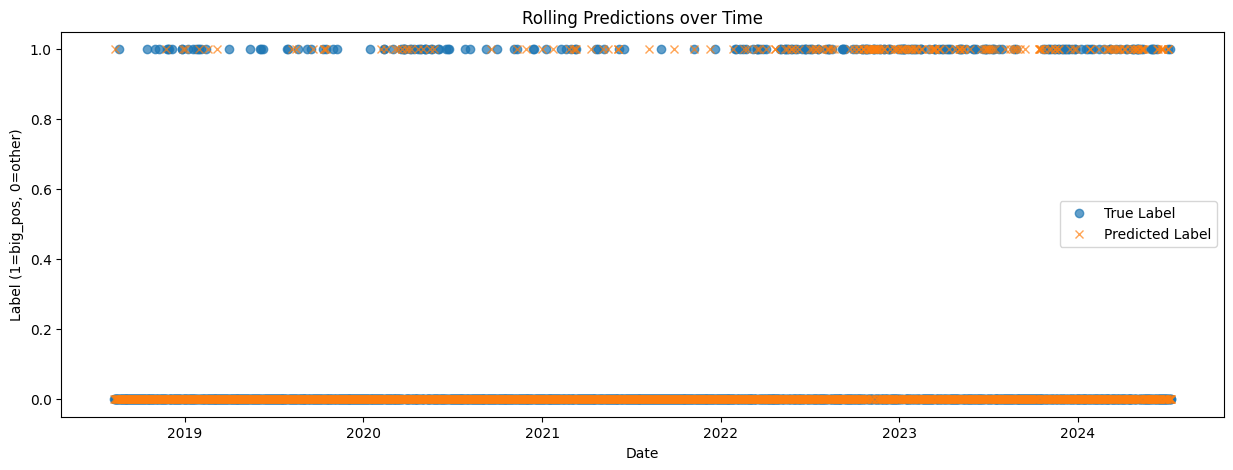

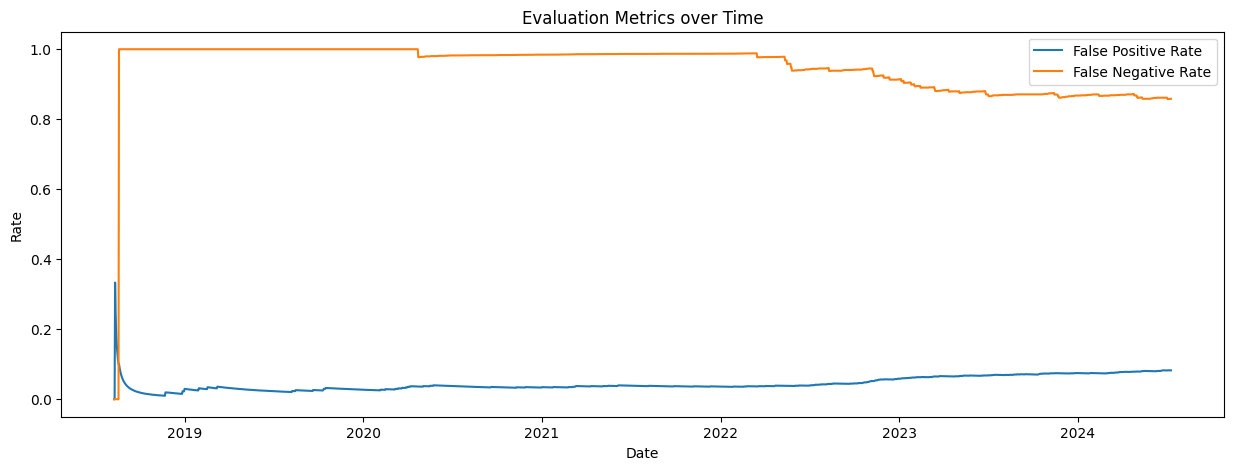

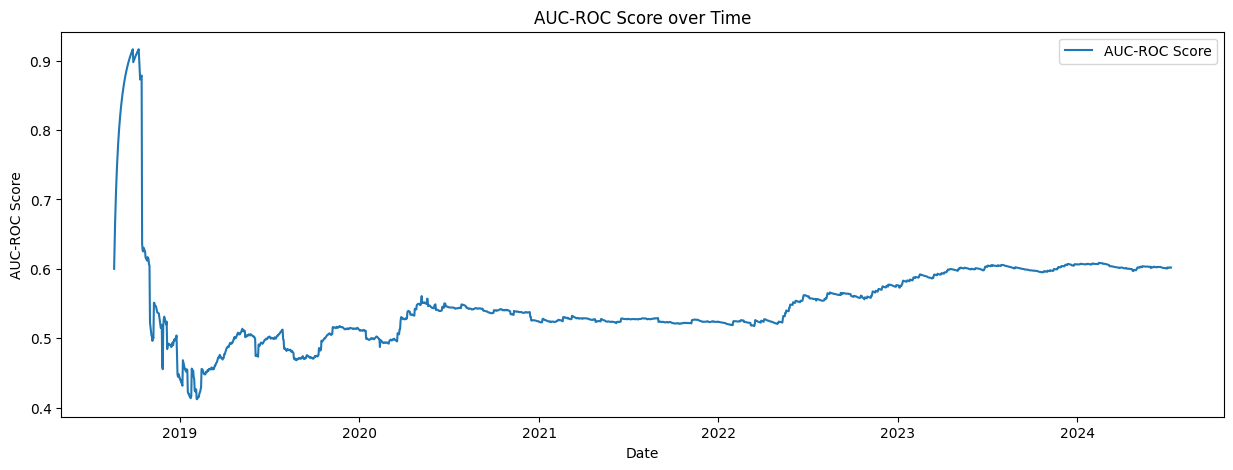

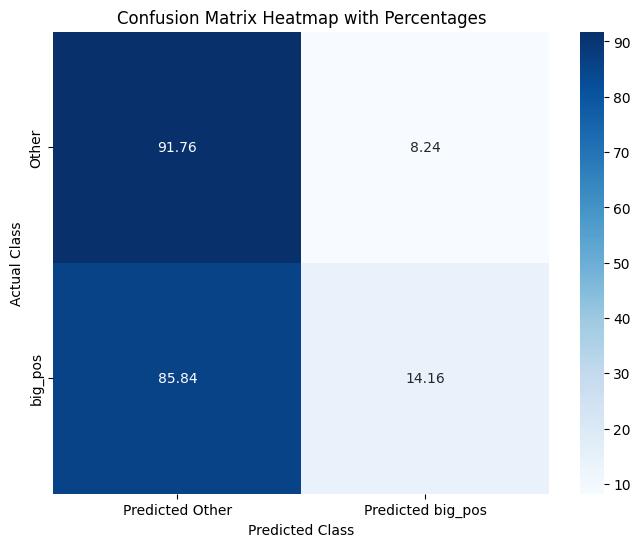

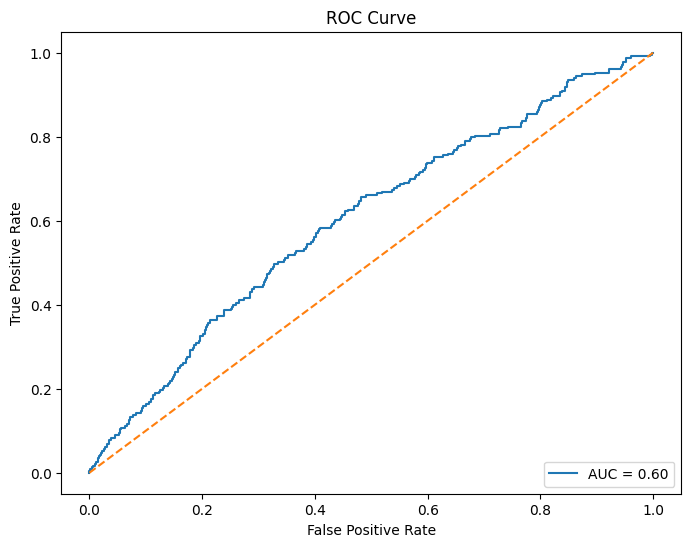

In [77]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Assume X is already loaded with the specified columns and DatetimeIndex

# Step 1: Compute daily returns based on closing prices
X['return'] = X['close'].pct_change()
print('After computing daily returns:', X.shape)

# Step 2: Compute intraday return and volatility
X['intraday_return'] = (X['close'] - X['open']) / X['open']
X['volatility'] = (X['high'] - X['low']) / X['low']
print('After computing intraday return and volatility:', X.shape)

# Step 3: Remove initial NaN values resulting from pct_change
X.dropna(inplace=True)
print('After dropping NaN values:', X.shape)

# Step 4: Define return classes based on specific criteria
# Compute the 10th and 90th percentiles
q10 = X['return'].quantile(0.10)
q90 = X['return'].quantile(0.90)
print('10th percentile (q10):', q10)
print('90th percentile (q90):', q90)

# Function to assign return classes
def assign_class(ret, q10, q90):
    if ret <= q10:
        return 'big_neg'  # Class 0
    elif ret < 0:
        return 'neg'      # Class 1
    elif ret < 0.001:
        return 'sideways' # Class 2
    elif ret < q90:
        return 'pos'      # Class 3
    else:
        return 'big_pos'  # Class 4

# Step 5: Assign return classes
X['return_class'] = X['return'].apply(lambda x: assign_class(x, q10, q90))
print('After assigning return classes:', X.shape)

# Step 6: Map return classes to numerical values for modeling purposes
class_mapping = {
    'big_neg': 0,
    'neg': 1,
    'sideways': 2,
    'pos': 3,
    'big_pos': 4
}
X['return_class_num'] = X['return_class'].map(class_mapping)
print('After mapping return classes to numbers:', X.shape)

# Step 7: Create the target variable (shifted return_class)
X['target_class'] = X['return_class'].shift(-1)
X['target'] = X['target_class'].apply(lambda x: 1 if x == 'big_pos' else 0)
print('After creating target variable:', X.shape)

# Drop the last row with NaN target
X.dropna(inplace=True)
print('After dropping NaN target row:', X.shape)

# Step 8: Prepare features and target variable
features = ['return', 'intraday_return', 'volatility', 'volume', 'return_class_num']
target = 'target'

# Step 9: Initialize lists to store results
dates = []
true_labels = []
predictions = []
probabilities = []
cumulative_true_labels = []
cumulative_predictions = []
cumulative_probabilities = []
auc_scores = []

# Start date after one year
start_date = X.index[0] + pd.DateOffset(years=1)
if start_date not in X.index:
    start_date = X.index[X.index.get_loc(start_date, method='nearest')]
start_index = X.index.get_loc(start_date)
print('Training starts from:', start_date)

# Step 10: Expanding window training and evaluation
for i in range(start_index, len(X)-1):
    # Expanding window training data
    train_data = X.iloc[:i]
    test_data = X.iloc[i:i+1]
    
    # Prepare training and testing sets
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # Calculate scale_pos_weight for handling class imbalance
    num_negative = (y_train == 0).sum()
    num_positive = (y_train == 1).sum()
    if num_positive == 0:
        scale_pos_weight = 1
    else:
        scale_pos_weight = num_negative / num_positive

    # Define XGBoost classifier
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
    model.fit(X_train, y_train)
    
    # Make prediction
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store results
    dates.append(X.index[i+1])  # Prediction is for next day
    true_labels.append(y_test.values[0])
    predictions.append(y_pred[0])
    probabilities.append(y_prob[0])
    cumulative_true_labels.append(y_test.values[0])
    cumulative_predictions.append(y_pred[0])
    cumulative_probabilities.append(y_prob[0])
    
    # Compute AUC-ROC score cumulatively
    if len(set(cumulative_true_labels)) > 1:
        auc = roc_auc_score(cumulative_true_labels, cumulative_probabilities)
        auc_scores.append(auc)
    else:
        auc_scores.append(np.nan)  # Cannot compute AUC with only one class

print('Completed rolling predictions.')

# Step 11: Compute cumulative metrics over time
false_positive_rates = []
false_negative_rates = []

for i in range(len(cumulative_true_labels)):
    current_true_labels = cumulative_true_labels[:i+1]
    current_predictions = cumulative_predictions[:i+1]
    current_probabilities = cumulative_probabilities[:i+1]
    
    cm = confusion_matrix(
        current_true_labels,
        current_predictions,
        labels=[0, 1]
    )
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = cm[0,0]
        fp = cm[0,1]
        fn = 0
        tp = 0
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)

print('Computed cumulative metrics.')

# Step 12: Create DataFrame for rolling predictions
results_df = pd.DataFrame({
    'Date': dates,
    'True_Label': true_labels,
    'Prediction': predictions,
    'Probability': probabilities
}).set_index('Date')

print('Rolling predictions table:')
print(results_df.head())

# Step 13: Visualization

# Plot rolling predictions
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, results_df['True_Label'], label='True Label', marker='o', linestyle='', alpha=0.7)
plt.plot(results_df.index, results_df['Prediction'], label='Predicted Label', marker='x', linestyle='', alpha=0.7)
plt.legend()
plt.title('Rolling Predictions over Time')
plt.xlabel('Date')
plt.ylabel('Label (1=big_pos, 0=other)')
plt.show()

# Plot evaluation metrics over time
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, false_positive_rates, label='False Positive Rate')
plt.plot(results_df.index, false_negative_rates, label='False Negative Rate')
plt.legend()
plt.title('Evaluation Metrics over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.show()

# Plot AUC-ROC score over time
plt.figure(figsize=(15, 5))
plt.plot(results_df.index, auc_scores, label='AUC-ROC Score')
plt.legend()
plt.title('AUC-ROC Score over Time')
plt.xlabel('Date')
plt.ylabel('AUC-ROC Score')
plt.show()

# Step 14: Visualize confusion matrix as heatmap
# Compute final confusion matrix
final_cm = confusion_matrix(
    cumulative_true_labels,
    cumulative_predictions,
    labels=[0, 1]
)

# Calculate percentages
cm_sum = final_cm.sum(axis=1)[:, np.newaxis]
cm_percent = final_cm.astype('float') / cm_sum * 100
cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero

# Create DataFrame for heatmap
cm_df = pd.DataFrame(
    cm_percent,
    index=['Other', 'big_pos'],
    columns=['Predicted Other', 'Predicted big_pos']
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix Heatmap with Percentages')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Step 15: Plot AUROC curve
fpr, tpr, thresholds = roc_curve(cumulative_true_labels, cumulative_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_scores[-1]:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
